Systematic risk is the risk that affects the entire market. In any trading strategy, we need to consider the impact of systematic risk. There needs to be some risk in a strategy to make money, but systematic risk cannot be diversified away.

So, we need to build a hedge to get rid of it.

By hedging systematic risk, we can better protect our strategies and ultimately outperform the market.

After having taught 1,000+ in my course, I can say with confidence most people do not hedge. Or if they do, it’s ineffective.

By reading today’s newsletter, you’ll see how an effective hedge can improve performance.



- Download data and construct a portfolio  
- Hedging systematic sector risk  
- Calculating the effective breadth

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

In [2]:
tickers = ["WFC", "JPM", "USB", "XOM", "VLO", "SLB"]
data = yf.download(tickers, start="2015-01-01", end="2023-12-31")["Close"]
returns = data.pct_change().dropna()
returns.head(3)

[*********************100%%**********************]  6 of 6 completed


,JPM,SLB,USB,VLO,WFC,XOM
Date,,,,,,
2015-01-05,-0.031045,-0.027081,-0.024091,-0.041120,-0.027422,-0.027362
2015-01-06,-0.025929,-0.019556,-0.013257,-0.012223,-0.020865,-0.005316
2015-01-07,0.001526,-0.000122,0.008802,-0.007760,0.005951,0.010133


In [8]:
corr = returns.corr()
print(f'The average pairwise correlation across the six assets in our portfolio is = {corr}\n')

The average pairwise correlation across the six assets in our portfolio is =           JPM       SLB       USB       VLO       WFC       XOM
JPM  1.000000  0.558652  0.808866  0.541143  0.817047  0.569751
SLB  0.558652  1.000000  0.554450  0.644270  0.531008  0.765141
USB  0.808866  0.554450  1.000000  0.547140  0.806949  0.542436
VLO  0.541143  0.644270  0.547140  1.000000  0.512828  0.668644
WFC  0.817047  0.531008  0.806949  0.512828  1.000000  0.554469
XOM  0.569751  0.765141  0.542436  0.668644  0.554469  1.000000



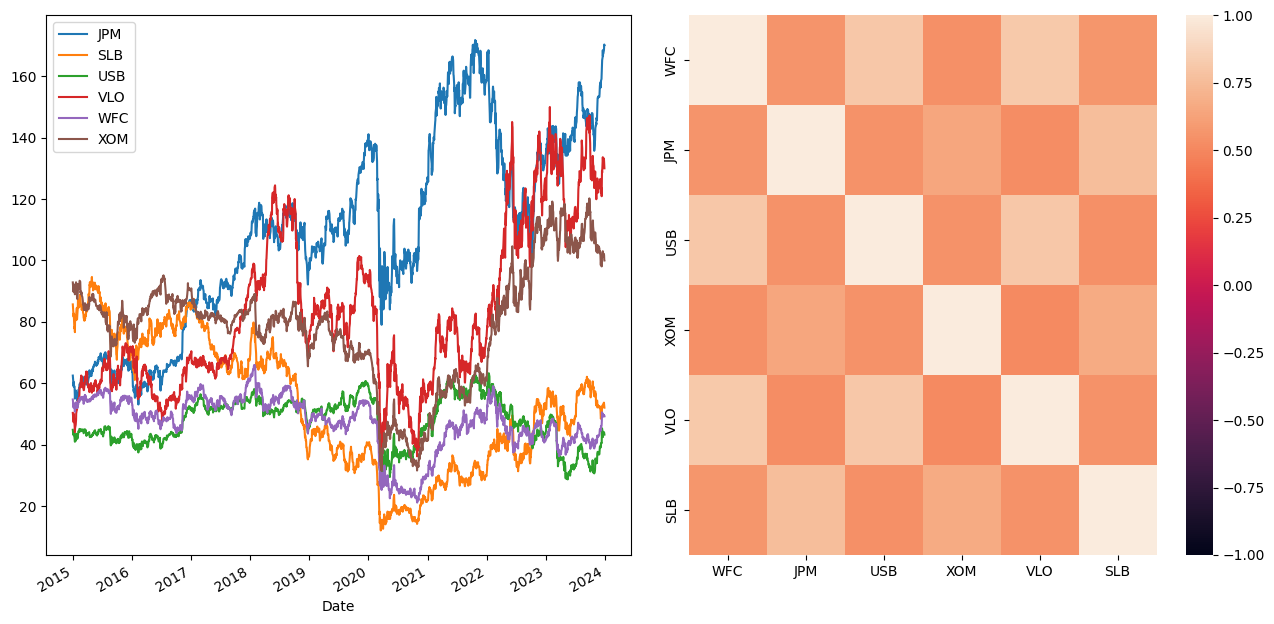

In [6]:
fig, (ax1, ax2) = plt.subplots(figsize = (13,7), ncols=2)
fig.tight_layout()

left = data.plot(ax=ax1)

right = sns.heatmap(
    corr,
    ax=ax2, vmin=-1, vmax=1,
    xticklabels=tickers, yticklabels=tickers
)

### Hedging systematic sector risk

In [10]:
#  financial sector, energy sector, and overall market.
market_symbols = ["XLF", "SPY", "XLE"]
sector_1_stocks = ["WFC", "JPM", "USB"]
sector_2_stocks = ["XOM", "VLO", "SLB"]

tickers = market_symbols + sector_1_stocks + sector_2_stocks
price = yf.download(tickers, start="2015-01-01", end="2023-12-31").Close
returns = price.pct_change().dropna()
returns.head(3)

[*********************100%%**********************]  9 of 9 completed


,JPM,SLB,SPY,USB,VLO,WFC,XLE,XLF,XOM
Date,,,,,,,,,
2015-01-05,-0.031045,-0.027081,-0.018060,-0.024091,-0.041120,-0.027422,-0.041368,-0.021027,-0.027362
2015-01-06,-0.025929,-0.019556,-0.009419,-0.013257,-0.012223,-0.020865,-0.014690,-0.015283,-0.005316
2015-01-07,0.001526,-0.000122,0.012461,0.008802,-0.007760,0.005951,0.002130,0.010487,0.010133


In [11]:
market_returns = returns["SPY"]
sector_1_returns = returns["XLF"]
sector_2_returns = returns["XLE"]

stock_returns = returns.drop(market_symbols, axis=1)
residuals_market = stock_returns.copy() * 0.0
residuals = stock_returns.copy() * 0.0

In [13]:
def ols_residual(y, x):
    results = sm.OLS(y, x).fit()
    return results.resid

sector_1_excess = ols_residual(sector_1_returns, market_returns)
sector_2_excess = ols_residual(sector_2_returns, market_returns)

for stock in sector_1_stocks:
    residuals_market[stock] = ols_residual(returns[stock], market_returns)
    residuals[stock] = ols_residual(residuals_market[stock], sector_1_excess)

for stock in sector_2_stocks:
    residuals_market[stock] = ols_residual(returns[stock], market_returns)
    residuals[stock] = ols_residual(residuals_market[stock], sector_2_excess)

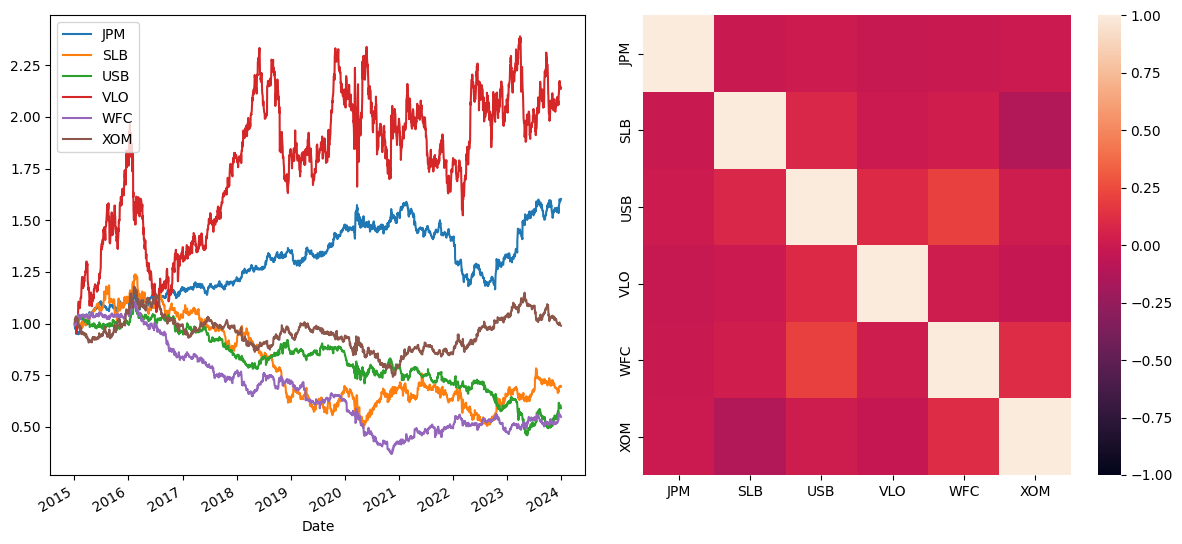

In [16]:
fig, (ax1, ax2) = plt.subplots(figsize = (12, 6), ncols=2)
fig.tight_layout()

corr = residuals.corr()

left = (1 + residuals).cumprod().plot(ax=ax1)

right = sns.heatmap(
    corr,
    ax=ax2,
    fmt="d",
    vmin=-1,
    vmax=1,
    xticklabels=residuals.columns,
    yticklabels=residuals.columns,
)

### Calculating effective breadth

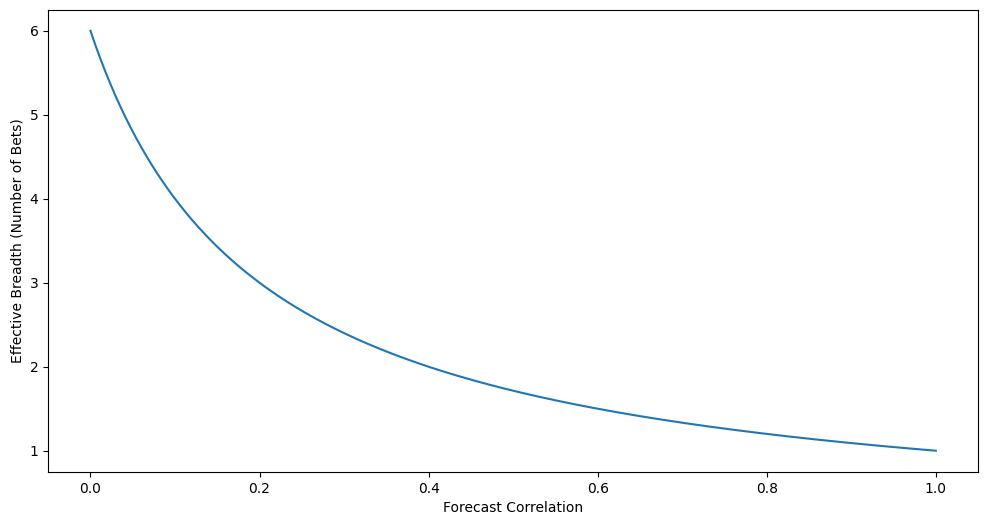

In [19]:
def buckle_BR_const(N, rho):
    return N/(1 + rho*(N - 1))

corr = np.linspace(start=0, stop=1.0, num=500)

plt.subplots(figsize = (12, 6))
plt.plot(corr, buckle_BR_const(6, corr))
plt.ylabel('Effective Breadth (Number of Bets)')
plt.xlabel('Forecast Correlation');